# **N Body Problem**
2022-07-01 | https://www.youtube.com/watch?v=otRtUiCcCh4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter

Newton's Law of Gravity states
$$F = ma = G\frac{Mm}{r^2}$$
hence, $a=G\frac{M}{r^2}$.

For a collection of masses, written in terms of vectors, we get a second-order ODE:
$$\frac{d^2\vec{r}_i}{dt^2} = \sum_{j \neq i} G\frac{m_j}{r^3_{ij}} \vec{r}_{ij}$$

where $\vec{r}_i$ and $m_i$ are the location and mass of the ith particle respectively. $\vec{r}_{ij} = \vec{r}_j - \vec{r}_i$
(the tail of this vector is at $\vec{r}_i$ and points to $\vec{r}_j$).

Dimensions for this problem are too small for efficient computation ($G \approx 6.67 \times 10^{-11}$). So, convert to dimensionless quantities:

$$\frac{d^2(L\vec{r}_i/L)}{dt^2} = \sum_{j \neq i} G\frac{Mm_j/M}{L^3r^3_{ij}/L^3} L\vec{r}_{ij}/L$$

$$\frac{Ld^2(\vec{r}'_i)}{dt^2} = \sum_{j \neq i} G\frac{Mm_j'}{L^3r'^3_{ij}} L\vec{r}'_{ij}$$

$$\frac{L^3}{GM}\frac{d^2(\vec{r}'_i)}{dt^2} = \sum_{j \neq i} \frac{m_j'}{r'^3_{ij}} \vec{r}'_{ij}$$

$$\frac{d^2(\vec{r}'_i)}{d\left(t\sqrt{\frac{GM}{L^3}}\right)^2} = \sum_{j \neq i} \frac{m_j'}{r'^3_{ij}} \vec{r}'_{ij}$$

$$\frac{d^2\vec{r}'_i}{dt'^2} = \sum_{j \neq i} \frac{m'_j}{r'^3_{ij}} \vec{r}'_{ij}$$

where
- $\vec{r}'_i = \vec{r}_i/L$ and $\vec{r}'_{ij} = \vec{r}_{ij}/L$, for a characteristic length $L$
- $m'_i = m_i/L$, for a characteristic mass $M$
- $t' = t\sqrt{GM/L^3}$

Drop the primes for the rest of the code, assuming everything is dimensionless. We can solve for the motion of the object, as a function of dimensionless time $t'$, then scale to $t$ using
$$t = t' \sqrt{L^3/GM}$$

## N=2 Body Problem

To simulate Earth's motion around the Sun, set
- $M = \text{mass of Earth} = 5.97 \times 10^{24} \ \text{kg}$
- $L = \text{Earth-Sun distance} = 1.5 \times 10^{11} \ \text{m}$

In [28]:
# 1: Earth
# 2: Sun

# Masses
m1 = 1
m2 = 333000  # Sun is 333000x heavier than Earth

# Initial positions
x1_0 = 1
y1_0 = 0

x2_0 = 0
y2_0 = 0

# Initial velocities
vx1_0 = 0
vy1_0 = np.sqrt(m2)  # Circular motion: v=sqrt(a*r) with a=m2 (since G=1, r12=1)

vx2_0 = 0
vy2_0 = 0

Note that any second-order ODE

$$\frac{d^2 y}{dt^2} = F\left(y, \frac{dy}{dt}, t \right)$$

can be written as two coupled first-order ODEs after defining $v_y = dy/dt$:

$$\begin{cases}
    \frac{dy}{dt} = v_y \\
    \frac{dv_y}{dt} = F\left(y, v_y, t \right)
\end{cases}$$

So, we define our system of what we need to solve for as
$$\vec{S} = (x_1, y_1, x_2, y_2, v_{x1}, v_{y1}, v_{x2}, v_{y2})$$

We need to write in a function that takes in $\vec{S}$ and returns $d\vec{S}/dt$.

In [29]:
def dSdt(S, t):
    x1, y1, x2, y2, vx1, vy1, vx2, vy2 = S
    r12 = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    return [
        vx1, vy1, vx2, vy2,
        m2/r12**3 * (x2-x1),  # ax1
        m2/r12**3 * (y2-y1),  # ay1
        m1/r12**3 * (x1-x2),  # ax2
        m1/r12**3 * (y1-y2),  # ay2
    ]

In [30]:
# Array of times
t = np.linspace(0, 1, 10000)

In [31]:
# ODE solution
sol = odeint(dSdt, y0=[x1_0, y1_0, x2_0, y2_0, vx1_0, vy1_0, vx2_0, vy2_0], t=t)

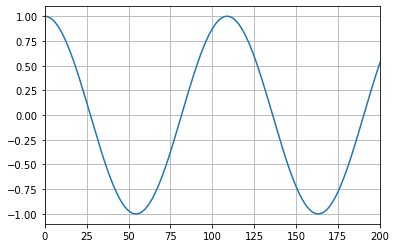

In [32]:
# Plot x as a function of dimensionless time
plt.plot(sol.T[0])
plt.xlim(0, 200)
plt.grid()

In [33]:
# Convert dimensionless time to years

# 1) Convert to seconds (SI units) using the conversion factor
tt = np.sqrt((1.5e11)**3 / (6.67e-11 * 5.97e24))

# 2) Convert from seconds to years
tt = tt / (60*60*24*365.25) * np.diff(t)[0]  # per time step (in years)

In [34]:
# Extract ODE solutions
x1 = sol.T[0]
y1 = sol.T[1]
x2 = sol.T[2]
y2 = sol.T[3]

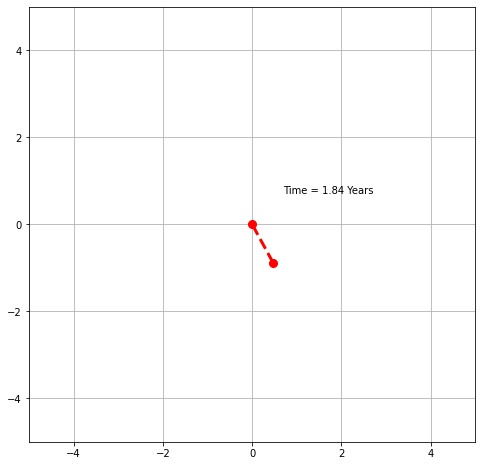

In [36]:
# Create animation
def animate(i):
    ln1.set_data([x1[i], x2[i]], [y1[i], y2[i]])
    text.set_text("Time = {:.2f} Years".format(i*tt))

fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.grid()
ln1, = plt.plot([], [], "ro--", lw=3, markersize=8)
text = plt.text(0.7, 0.7, "")
ax.set_ylim(-5, 5)
ax.set_xlim(-5, 5)
ani = animation.FuncAnimation(fig, animate, frames=200, interval=50)
ani.save("two_body.gif", writer="pillow", fps=30)

## N=3 Body Problem

- https://arxiv.org/abs/1303.0181
- https://arxiv.org/abs/1709.04775

These two papers look at the three body problem under the following initial conditions ($t=0$):
- $m_1 = m_2 = 1$, $m_3$ can vary
- $x_1 = -x_2 = -1$ and $x_3 = 0$
- $y_1 = y_2 = y_3 = 0$
- $v_{x1} = v_{x2} = v_1$, where $v_1$ is some defined speed
- $v_{y1} = v_{y2} = v_2$, where $v_2$ is some defined speed
- $v_{x3} = -2v_1/m_3$ and $v_{y3} = -2v_2/m_3$

Thus, the only parameters that are altered are $m_3$, $v_1$, and $v_2$. **These are states with zero angular momentum.**

See Table I from paper 1 and Table I from paper 2 for interesting stable configurations (hard to find!). Here are two:
1. From last row of Table I paper 2: $v_1 = 0.9911981217$, $v_2 = 0.7119472124$, and $m_3 = 4$
2. From second row of Table I paper 1: $v_1 = 0.39295$, $v_2 = 0.09758$, and $m_3 = 1$

In [27]:
# Parameters to change
m3 = 4
v1 = 0.9911981217
v2 = 0.7119472124

# Everything else frollows from the paper
m1 = 1
m2 = 1
m3 = m3

x1_0 = -1
y1_0 = 0

x2_0 = 1
y2_0 = 0

x3_0 = 0
y3_0 = 0

vx1_0 = v1
vy1_0 = v2

vx2_0 = v1
vy2_0 = v2

vx3_0 = -2*v1/m3
vy3_0 = -2*v2/m3

In [28]:
# Define the ODE system
def dSdt(t, S):
    x1, y1, x2, y2, x3, y3, vx1, vy1, vx2, vy2, vx3, vy3 = S
    r12 = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    r13 = np.sqrt((x3-x1)**2 + (y3-y1)**2)
    r23 = np.sqrt((x3-x2)**2 + (y3-y2)**2)
    return [
        vx1, vy1, vx2, vy2, vx3, vy3,
        m2/r12**3 * (x2-x1) + m3/r13**3 * (x3-x1),  # mass 1
        m2/r12**3 * (y2-y1) + m3/r13**3 * (y3-y1),
        m1/r12**3 * (x1-x2) + m3/r23**3 * (x3-x2),  # mass 2
        m1/r12**3 * (y1-y2) + m3/r23**3 * (y3-y2),
        m1/r13**3 * (x1-x3) + m2/r23**3 * (x2-x3),  # mass 3
        m1/r13**3 * (y1-y3) + m2/r23**3 * (y2-y3)
    ]

In [29]:
# Times to solve
t = np.linspace(0, 20, 1000)

Use the special `DOP853` solver as recommended by the paper. We need to set very small values for `rtol` and `atol` to ensure a proper solution.

In [30]:
sol = solve_ivp(
    dSdt, (0, 20),
    y0=[x1_0, y1_0, x2_0, y2_0, x3_0, y3_0, vx1_0, vy1_0, vx2_0, vy2_0, vx3_0, vy3_0],
    method="DOP853", t_eval=t, rtol=1e-10, atol=1e-13
)

In [31]:
# Get solutions for the three particles
t = sol.t

x1 = sol.y[0]
y1 = sol.y[1]

x2 = sol.y[2]
y2 = sol.y[3]

x3 = sol.y[4]
y3 = sol.y[5]

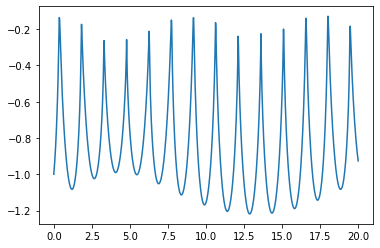

In [32]:
# Plot x_1 as a function of dimensionless time
plt.plot(t, x1)

In [33]:
# Get the actual times (assuming three suns orbiting at Earth-Sun distance)
tt = 1/np.sqrt(6.67e-11 * 1.99e30 / (1.5e11)**3)  # seconds
tt = tt / (60*60*24*365.25) * np.diff(t)[0]  # per time step (in years)

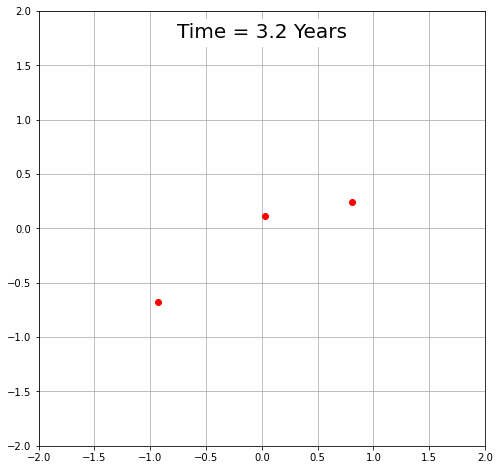

In [34]:
# Create animation
def animate(i):
    ln1.set_data([x1[i], x2[i], x3[i]], [y1[i], y2[i], y3[i]])
    text.set_text("Time = {:.1f} Years".format(i*tt))

fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.grid()
ln1, = plt.plot([], [], "ro", lw=3, markersize=6)
text = plt.text(0, 1.75, "asdasd", fontsize=20, backgroundcolor="white", ha="center")
ax.set_ylim(-2, 2)
ax.set_xlim(-2, 2)
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
ani.save("three_body.gif", writer="pillow", fps=30)